## Dissertation Project - News Summary Dissertation [100 marks]

### Motivation 

> 1. Provide tools for anyone needing to speed up their research process
> 2. Providing ways for user to quickly determine whether a piece of research is beneficial for their specific search terms




In [290]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Toggle code."></form>''')

### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
import string
import random
from tqdm.notebook import tqdm
import ipywidgets as widgets
import fitz

import numpy as np 
import pandas as pd
import math

import json

DATASET = "./Dataset/"

Detect which device (CPU/GPU) to use.

In [2]:
seed = 0
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed) 
torch.cuda.manual_seed_all(seed)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


### Overview

Summarisation model
> 1. Dataset preprocessing
> 2. Dataloader
> 3. RNN model definition
> 4. Model training
> 5. Model prediction evaluation
> 6. Dataset Exploration
> 7. Dataset modification/Data Augmentation
> 8. Model improvement
> 9. Model finalisation and evaluation

Paper querying
> 1. Attention on query (Return usefulness percentage
> 2. Evaluate performance


# Data preprocessing

In [5]:
# # Comment this block if dataset is reorganised
# DATA_DIR = "SSN/papers.SSN.jsonl"
# dataset_path = DATASET+DATA_DIR
# with open(dataset_path) as f:
#     lines = f.read().splitlines()
# df_inter = pd.DataFrame(lines)
# df_inter.columns = ['json_element']
# df_final = pd.json_normalize(df_inter['json_element'].apply(json.loads))
# df_final.to_json("./Dataset/SSN/SSN_Dataset.json")
# df_final

In [ ]:
# for i,summary in df_final.iterrows():
#     temp = summary["abstract"]
#     print(type(summary["abstract"]))
#     break

In [236]:
# #Comment this block if dataset is shortened
# DATA_DIR = "SSN/SSN_Dataset.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df

In [32]:
# df.iloc[140794]["section_names"]

['introduction',
 'quantum information theory preliminaries',
 'kk-minimal and kk-maximal operator spaces',
 'kk-super minimal and kk-super maximal operator systems',
 'norms on operator systems',
 'contractive maps as separability criteria']

Function to return index for conclusion section

In [12]:
# def trim_index(row):
#     return [row.index(x)+1 for x in row if x.startswith('conclusion') or x.startswith("summar")]

In [13]:
# def trim_text(text, index):
#     return text[0:index]

In [14]:
# # Comment this block if dataset is shortened
# # Trim text after conclusion
# indexes = []
# for i, row in df.iterrows():
#     section = row["section_names"]
#     #print(section)
#     index = trim_index(section)
#     #print(index)
#     if not index:
#         indexes.append(i)
#     # if section can be filtered
#     else:
#         index = index[0]
#         abstract = row["abstract"]
#         text = row["text"]
#         section = row["section_names"]
#         df.at[i, "section_names"] = trim_text(section, index)
#         df.at[i, "abstract"] = trim_text(abstract, index)
#         df.at[i, "text"] = trim_text(text, index)
# # dropping rows in dataframe that can't easily filter out reference section
# print(len(indexes))
# df.drop(indexes, inplace=True)
# df.to_json("./Dataset/SSN/SSN_Dataset_Short.json")

49413


35% of paper will be removed from the dataset due to it not having conclusion(s) and summary(ies) in their section titles, making it difficult to filter out the reference and appendix text

In [259]:
# DATA_DIR = "SSN/SSN_Dataset_Short.json"
# dataset_path = DATASET+DATA_DIR
# df = pd.read_json(dataset_path)
# df.reset_index(drop=True, inplace=True)
# df

See diversity in papers, select only computer science

In [249]:
# plot_points = df['domain'].value_counts()
# plot_points

[Physics]                          41291
[Computer science]                 19695
[Mathematics]                      17047
[Computer science, Mathematics]     5075
[]                                  3162
                                   ...  
[Geology, Philosophy]                  1
[Computer science, Philosophy]         1
[Art, Computer science]                1
[Materials science, Geography]         1
[Biology, Computer science]            1
Name: domain, Length: 156, dtype: int64

In [260]:
# df = df.loc[df['domain'].isin([['Computer science']])]
# df.to_json("./Dataset/SSN/SSN_Dataset_CompSci_Short.json")
# df

In [3]:
DATA_DIR = "SSN/SSN_Dataset_CompSci_Short.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df.reset_index(drop=True, inplace=True)
df

,paper_id,title,abstract,section_names,domain,text
0,9195903,Robust Face Alignment Using a Mixture of Invar...,"[face alignment , which is the task of finding...","[introduction, previous work, our approach, su...",[Computer science],[[face alignment refers to finding the pixel l...
1,56895423,TEST: A Terminology Extraction System for Tech...,[tracking developments in the highly dynamic d...,"[introduction, related work, dataset preparati...",[Computer science],[[with the ubiquity of online resources and th...
2,15943840,Dynamic autotuning of adaptive fast multipole ...,[we discuss an implementation of adaptive fast...,"[introduction, fast multipole methods, well-se...",[Computer science],[[the inlineform0 -body simulation is an ubiqu...
3,189927954,NLH: A Blind Pixel-level Non-local Method for ...,[non - local self similarity ( nss ) is a powe...,"[introduction, related work, proposed blind pi...",[Computer science],[[digital images are often subject to noise de...
4,202120843,Adversarial Examples with Difficult Common Wor...,[despite the success of deep models for paraph...,"[introduction, deep paraphrase identification,...",[Computer science],[[paraphrase identification is to determine wh...
...,...,...,...,...,...,...
19690,16595919,Domain Adaptation of Recurrent Neural Networks...,[the goal of this paper is to use multi - task...,"[introduction, model, data, experiments, train...",[Computer science],[[slot filling models are a useful method for ...
19691,54202209,Anchor Box Optimization for Object Detection,"[in this paper , we propose a general approach...","[introduction, related work, relative offset p...",[Computer science],[[object detection plays an important role in ...
19692,1853209,Construction of polar codes for arbitrary disc...,[it is known that polar codes can be efficient...,"[introduction, preliminaries on polar coding, ...",[Computer science],[[arıkan 's polar codes form the first expli...
19693,16428243,Action Recognition with Joint Attention on Mul...,[we propose a novel deep supervised neural net...,"[introduction, related work, integrating track...",[Computer science],[[action recognition and description of vide...


In [4]:
summary_df = df[["abstract", "text"]]
summary_df

,abstract,text
0,"[face alignment , which is the task of finding...",[[face alignment refers to finding the pixel l...
1,[tracking developments in the highly dynamic d...,[[with the ubiquity of online resources and th...
2,[we discuss an implementation of adaptive fast...,[[the inlineform0 -body simulation is an ubiqu...
3,[non - local self similarity ( nss ) is a powe...,[[digital images are often subject to noise de...
4,[despite the success of deep models for paraph...,[[paraphrase identification is to determine wh...
...,...,...
19690,[the goal of this paper is to use multi - task...,[[slot filling models are a useful method for ...
19691,"[in this paper , we propose a general approach...",[[object detection plays an important role in ...
19692,[it is known that polar codes can be efficient...,[[arıkan 's polar codes form the first expli...
19693,[we propose a novel deep supervised neural net...,[[action recognition and description of vide...


Check if any columns contain empty values

In [17]:
# summary_df.isnull().any()

abstract    False
text        False
dtype: bool

\'hi\' \ is used for space <br>
random space, which is used for reference [15] quote box <br>
sec ref is hyperlink to a section <br>
fig ref is hyperlink to a figure <br>
inlineform <br>
displayform are both symbols, both contains numbers in string <br>
remove all forms and remove all symbols but keep numbers <br>

In [5]:
def contain_let(string):
    return any(char.isalpha() for char in string)

In [6]:
def contain_num(string):
    return any(char.isdigit() for char in string)

In [7]:
def contain_special(string, allowed):
    '''
    allowed is a list containing allowed symbols to pass detection
    '''
    return any(not(char.isalpha() or char.isdigit()) and (char not in allowed) for char in string)

In [8]:
def cleanLine(line, text=True):
    "text parameter is to indicate whether the line is from text or abstract"
    symbols = ["'", "’"]
    stop_words = list(ENGLISH_STOP_WORDS)
    
    clean_line = line.lower()
    
    # fix apostrophes in line by removing apostrophe with no following alphabet character
    clean_line = clean_line.replace("' ", " ")
    # remove apostrophe if last character is apostrophe
    if clean_line and (clean_line[-1] == "'"):
        clean_line = clean_line[0:len(clean_line)-1]
    # fix apostrophes in line by removing space before single quote
    clean_line = clean_line.replace(" '", "'")

    
    # clean line = clean line remove forms
    words = clean_line.split()
    #  remove forms, words with special characters inside
    # if contain letter and number
    # if contain special character not in allowed symbols and removing punctuations
    # then remove
    words = [x.replace(x, "") if (contain_let(x) and contain_num(x))
             or contain_special(x, symbols)
             else x for x in words]
    # remove empty strings
    words = filter(None, words)

    # stop words from sklearn, remove stop words
    if text:
        words = [x for x in words if not x in stop_words]
        
     # combine the items into 1 string
    clean_line = ' '.join(words)
    

    return clean_line

In [9]:
def concatParagraph(paragraph, text=True):
    clean_paragraph = ""
    for line in paragraph:
        lines = cleanLine(line)
        clean_paragraph += cleanLine(lines, text) + " "
        #print(clean_paragraph)
        
    return(clean_paragraph.strip())

In [10]:
def concatPaper(paper, text=True):
    clean_paper = ""
    for paragraph in paper:
        clean_paper += concatParagraph(paragraph, text) + " "
    return(clean_paper.strip())

In [11]:
for i, row in tqdm(summary_df.iterrows(), total=df.shape[0]):
    abstract = row["abstract"]
    paper = row["text"]
    
    summary_df.at[i, "abstract"] = concatParagraph(abstract, text=False)
    summary_df.at[i, "text"] = concatPaper(paper)

  0%|          | 0/19695 [00:00<?, ?it/s]

In [12]:
summary_df.to_json("./Dataset/SSN/SSN_Dataset_CompSci_Short_Clean_HalfStop.json")
summary_df

,abstract,text
0,face alignment task finding locations set faci...,face alignment refers finding pixel locations ...
1,tracking developments highly dynamic data tech...,ubiquity online resources massive growth news ...
2,discuss implementation adaptive fast multipole...,simulation ubiquitous problem computational sc...
3,non local self similarity nss powerful prior n...,digital images subject noise degradation acqui...
4,despite success deep models paraphrase identif...,paraphrase identification determine pair sente...
...,...,...
19690,goal paper use multi task learning efficiently...,slot filling models useful method simple natur...
19691,paper propose general approach optimize anchor...,object detection plays important role real app...
19692,known polar codes efficiently constructed bina...,arıkan's polar codes form explicit family bina...
19693,propose novel deep supervised neural network t...,action recognition description videos fundamen...


In [43]:
DATA_DIR = "SSN/SSN_Dataset_CompSci_Short_Clean_HalfStop.json"
dataset_path = DATASET+DATA_DIR
df = pd.read_json(dataset_path)
df

,abstract,text
0,face alignment task finding locations set faci...,face alignment refers finding pixel locations ...
1,tracking developments highly dynamic data tech...,ubiquity online resources massive growth news ...
2,discuss implementation adaptive fast multipole...,simulation ubiquitous problem computational sc...
3,non local self similarity nss powerful prior n...,digital images subject noise degradation acqui...
4,despite success deep models paraphrase identif...,paraphrase identification determine pair sente...
...,...,...
19690,goal paper use multi task learning efficiently...,slot filling models useful method simple natur...
19691,paper propose general approach optimize anchor...,object detection plays important role real app...
19692,known polar codes efficiently constructed bina...,arıkan's polar codes form explicit family bina...
19693,propose novel deep supervised neural network t...,action recognition description videos fundamen...


In [44]:
rows = []

t_max= 1973
a_max=  93
t_min=  669
a_min=  39
for i, row in df.iterrows():
    t_word = len(row["text"].split())
    a_word = len(row["abstract"].split())
    if ((t_word > t_max or t_word < t_min) or (a_word > a_max or a_word < a_min)):
        rows.append(i)
df.drop(rows, inplace=True)
df.reset_index(drop=True, inplace=True)
df.to_json("./Dataset/SSN/SSN_Dataset_CompSci_Short_Clean_150_HalfStop.json")
df

,abstract,text
0,tracking developments highly dynamic data tech...,ubiquity online resources massive growth news ...
1,paper propose new method enhance mapping paral...,large scale graph based applications numerical...
2,investigate models mitogenactivated protein ki...,mathematical modelling intra cellular biologic...
3,present new approach pretraining bi directiona...,language model pretraining recently shown prov...
4,saliency detection active topic multimedia fie...,salient object detection process getting visua...
...,...,...
6192,large improvement existing hammer style proof ...,proof automation interactive theorem provers i...
6193,present neural encoder decoder model convert i...,optical character recognition ocr commonly use...
6194,ability detect pedestrians moving objects cruc...,autonomous cars currently primed mass adoption...
6195,goal paper use multi task learning efficiently...,slot filling models useful method simple natur...


In [45]:
class Vocabulary(object):
    """ Simple vocabulary wrapper which maps every unique word to an integer ID. """
    def __init__(self):
        # intially, set both the IDs and words to dictionaries with special tokens
        self.word2idx = {'<start>': 0, '<end>': 1, '<pad>':2, '<unk>':3}
        self.idx2word = {0: '<start>', 1: '<end>', 2: '<pad>', 3: '<unk>'}
        self.idx = 4

    def add_word(self, word):
        # if the word does not already exist in the dictionary, add it
        if not word in self.word2idx:
            # this will convert each word to index and index to word as you saw in the tutorials
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            # increment the ID for the next word
            self.idx += 1

    def __call__(self, word):
        # if we try to access a word not in the dictionary, return the id for <unk>
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]
    
    ## added function for utility
    def get_word(self,index):
        # this returns the word when given an index
        return self.idx2word[index]

    def __len__(self):
        return len(self.word2idx)


In [46]:
def build_vocab(data, freq):
    """ 
    Parses training set token file captions and builds a Vocabulary object and dataframe for 
    the image and caption data

    Returns:
        vocab (Vocabulary): Vocabulary object containing all words appearing more than min_frequency
    """
    MIN_FREQUENCY = freq
    word_mapping = Counter()

    # for index in df.index:
    for text in tqdm(data):
        for word in text.split():
            #print(word)
            if word in word_mapping:
                word_mapping[word] += 1
            else:
                word_mapping[word] = 1

    # create a vocab instance
    vocab = Vocabulary()

    # add the words to the vocabulary
    for word in word_mapping:
        if word_mapping[word] > MIN_FREQUENCY:
            vocab.add_word(word)

    return vocab


Convert DF to text

In [47]:
# text_txt = df['text']
# text_txt.to_csv("text_118_NoStop.txt", header=False,index=False)
# # write to file. 

In [48]:
# vocab_model = fasttext.train_unsupervised('text_NoStop.txt', minn=2, epoch=10)
# vocab_model.save_model("fastText_NoStop.bin")

In [49]:
abstract_vocab = build_vocab(df["abstract"], 0)

  0%|          | 0/6197 [00:00<?, ?it/s]

In [50]:
text_vocab = build_vocab(df["text"], 0)

  0%|          | 0/6197 [00:00<?, ?it/s]

In [51]:
print("abstract vocab", len(abstract_vocab))
print("text vocab", len(text_vocab))

abstract vocab 18210
text vocab 72797


In [52]:
def tokenise(vocab, text):
    word_ids = []
    for word in text.split():
        word_ids.append(vocab(word))
    #word_ids.append(vocab("<end>"))
#     while len(word_ids) < max_len:
#             word_ids.append(vocab("<pad>"))
    return word_ids

In [53]:
ABSTRACT_MAX = 100
TEXT_MAX = 3000

In [54]:
class SSNDataset(Dataset):
    def __init__(self, df, a_vocab, t_vocab):

        self.df = df
        self.a_vocab = a_vocab
        self.t_vocab = t_vocab
        self.abstract_max_len = ABSTRACT_MAX
        self.text_max_len = TEXT_MAX

    def __getitem__(self, index):
        # return word_id
        abstract = self.df.iloc[index]["abstract"]
        text = self.df.iloc[index]["text"]
        
        a_word_ids = tokenise(self.a_vocab, abstract)
        t_word_ids = tokenise(self.t_vocab, text)

        a_length = len(a_word_ids)
        t_length = len(t_word_ids)
    
        return a_word_ids, t_word_ids# torch.tensor(t_length)# torch.tensor(t_length)

    def __len__(self):
        return len(self.df)


In [55]:
def find_max_list(lis):
    list_len = [len(i) for i in lis]
    return (max(list_len))

In [56]:
def text_collate_fn(data):
    """ Creates mini-batch tensors from the list of tuples (image, caption).
    Args:
        data: list of tuple of 2 word ids
        - abstract id
        - text id
    Returns:
        abstract list ids
        text list ids
    """

    
    abstracts, texts = zip(*data)
    abstract_list = []
    text_list = []
    for i in range(len(texts)):
        while len(texts[i]) < find_max_list(texts):
            texts[i].append(text_vocab("<pad>"))
        text_list.append(torch.tensor(texts[i]))
        
    for i in range(len(abstracts)):
        
        while len(abstracts[i]) < ABSTRACT_MAX:
            abstracts[i].append(abstract_vocab("<pad>"))
        abstract_list.append(torch.tensor(abstracts[i]))


#     abstracts = torch.tensor(abstracts)
#     texts = torch.tensor(texts)
#     abstracts = [ torch.Tensor(abstract).to(device) for abstract in abstracts ]
# if batch size is 1 then use [0]
    abstracts = torch.stack(tuple(abstract_list), 0)
    #abstracts = abstracts.unsqueeze(0)
#     abstracts = torch.nn.utils.rnn.pad_sequence(abstracts)
    texts = torch.stack(tuple(text_list), 0)
    #texts = texts.unsqueeze(0)

    return abstracts, texts


# Dataloader

Split dataset

In [57]:
train_data, test_data = train_test_split(df, random_state=seed, train_size = 0.7)
train_data, valid_data = train_test_split(train_data, random_state=seed, train_size=0.8)

In [58]:
train_set = SSNDataset(train_data, abstract_vocab, text_vocab)
valid_set = SSNDataset(test_data, abstract_vocab, text_vocab)
test_set = SSNDataset(test_data, abstract_vocab, text_vocab)

In [59]:
train_loader = DataLoader(train_set, batch_size=4, shuffle=True, collate_fn=text_collate_fn) # num_worker can't be 2+ as the time it 
                                                                 # takes to build iter is much longer
valid_loader = DataLoader(valid_set, batch_size=4, shuffle=True, collate_fn=text_collate_fn)

In [25]:
all_set = SSNDataset(df, abstract_vocab, text_vocab)
all_loader = DataLoader(all_set, batch_size=1, shuffle=True, collate_fn=text_collate_fn)
abstracts = []
texts = []
for i, (abstract, text) in tqdm(enumerate(all_loader), total=len(all_loader)):
    a_size = list(abstract.size())[1]

    t_size = list(text.size())[1]
    abstracts.append(a_size)
    texts.append(t_size)
numbers = list(range(len(all_loader)))

  0%|          | 0/19695 [00:00<?, ?it/s]

In [26]:
from statistics import mean
print("max length for abstract: ",max(abstracts))
print("max length for text: ",max(texts))
print("min length for abstract: ",min(abstracts))
print("min length for text: ",min(texts))
print("average length for abstract: ",math.floor(mean(abstracts)))
print("average length for text: ",math.floor(mean(texts)))

max length for abstract:  187
max length for text:  4540
min length for abstract:  9
min length for text:  12
average length for abstract:  95
average length for text:  2000


In [40]:
print("50th percentile: ", np.percentile(texts, 40))
print("50th percentile: ", np.percentile(abstracts, 40))
print("1st percentile: ", np.percentile(texts, 1))
print("1st percentile: ", np.percentile(abstracts, 1))

50th percentile:  1802.0
50th percentile:  86.0
1st percentile:  668.94
1st percentile:  39.0


In [28]:
a_perc = []
t_perc = []
for i in range(100):
    i +=1
    a_perc.append(np.percentile(abstracts, i))
    t_perc.append(np.percentile(texts,i))

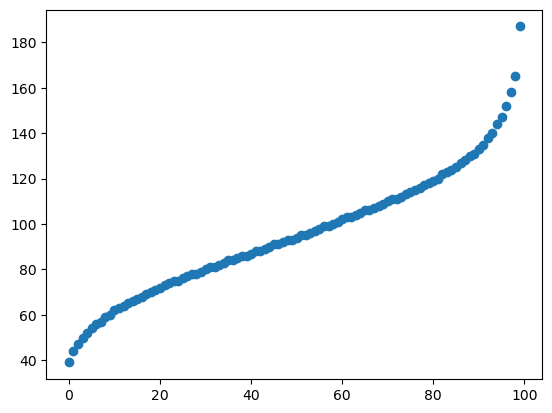

In [29]:
plt.scatter(range(len(a_perc)),a_perc)
plt.show()

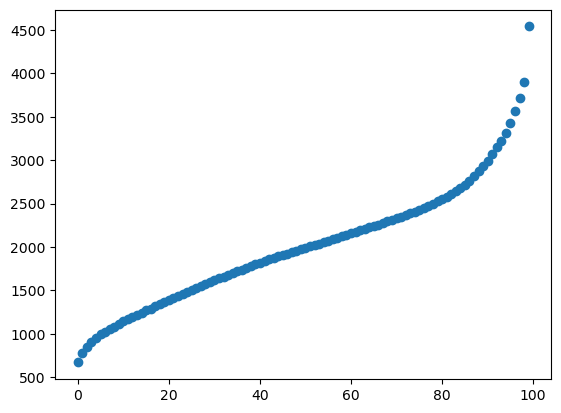

In [30]:
plt.scatter(range(len(t_perc)), t_perc)
plt.show()

# RNN Model definition

In [110]:
from gensim.models import Word2Vec
vec = Word2Vec(sentences="text_118_NoStop.txt", vector_size=300, window=5, min_count=1, workers=6)
vec.save("word2vec.model")

In [60]:
class Encoder(nn.Module):
    def __init__(self, voc_size, num_layer, hidden_dim):
        super(Encoder, self).__init__()
        self.device = device
        self.hidden_dim = hidden_dim
        self.num_layer = num_layer
        
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.lstm = nn.LSTM(
            input_size=hidden_dim,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=True
        )
        self.dropout = nn.Dropout(0.2)
        self.relu = nn.ReLU()
        self.fc_hidden = nn.Linear(hidden_dim*2, 
                                       hidden_dim)

    def forward(self, input):
        input = input.permute(1,0)
        #print(input.shape) #[batch, seq_len] -> [seq_len, batch]
        
        embedded = self.dropout(self.embeddings(input))
        # [batch, seq_len, hid] -> [seq_len, batch, hid]
        #print("E embedded:", embedded.shape)

        lengths = (input != 2).sum(1) # pad index = 2
        #print(lengths)
        batch_size = input.shape[0]
#         embedded = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), 
#                                                            batch_first=True,enforce_sorted=False)
#         embedded:  torch.Size([16125, 250])
#         embedded:  torch.Size([16])
#         print("embedded: ",embedded[0].shape)
#         print("embedded: ",embedded[1].shape)
        output, (hidden, cell) = self.lstm(embedded)
        #print("hid before",hidden.shape)
        hidden = self.fc_hidden(torch.cat((hidden[0:1], hidden[1:2]), dim=2))
        cell = self.fc_hidden(torch.cat((cell[0:1], cell[1:2]), dim=2))
        #output, lengths = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True,padding_value=2)
        lengths = lengths.to(device)
        #print("output: ",output.shape)
        # output [seq_len, batch, hid*2] supposed hid*1
        # hidden [1, seq_len, hid]
        #print("hid after",hidden.shape)
        #print("output", output)
        return output, hidden, cell, lengths

In [61]:
class Decoder(nn.Module):
    def __init__(self, voc_size, num_layer,hidden_dim):
        super(Decoder, self).__init__()
        self.embeddings = nn.Embedding(
            num_embeddings=voc_size,
            embedding_dim=hidden_dim
        )
        self.attention = Attention(hidden_dim,hidden_dim)
        self.lstm = nn.LSTM(
            input_size=hidden_dim*3,
            hidden_size=hidden_dim,
            num_layers=num_layer,
            bidirectional=False
        )
        self.dropout = nn.Dropout(0.3)
        self.fc = nn.Linear(
            in_features=hidden_dim,
            out_features=voc_size
        )
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1) # check
    

    def forward(self, input, hidden, cell,encoder_outputs, lengths): 
        input = input.unsqueeze(0) # [1,batch]
        #print("D input", input.shape)
        embedded = self.embeddings(input) # [batch, 256] -> [1, batch, dim] with unsqueeze
        #print("D embedded", embedded.shape)
    
        # hidden = [bathc, seq_len, hidden_dim]
        #hidden_permute = hidden.permute(0,1) # [1, 512]
        embedded = self.dropout(embedded)

        # mask to block decoder from knowing future sequences/block padding
#         max_len = lengths.max().item()
#         mask = torch.arange(max_len).expand(len(lengths), max_len) < lengths.unsqueeze(1).cpu()
        
#         mask = mask.to(device)
        mask=0

        context = self.attention(hidden, encoder_outputs, mask).to(device)
        #print("D embedded", embedded.shape)
        # [1, seq_len, dim*2]
        #print("context shape: ", context.shape) # context shape:  torch.Size([1, 1317, 500])
        rnn_input = torch.cat((context, embedded), dim=2) # []
        #print("D rnn_input", rnn_input.shape)
        decoder_output, (hidden, cell) = self.lstm(rnn_input, (hidden, cell))
        #print("D decode output:",decoder_output.shape)
        #print("D hidden", hidden.shape)
        #print("D hidden", hidden)
        #print("D cell", cell.shape)
        output = self.fc(decoder_output)
        output = output.squeeze(0)
        
        #print("D decode output:",decoder_output.shape)
        #output = decoder_output.squeeze(0)
        #print("D decode output:",output.shape)
        #output = self.logsoftmax(output)
        #print("D decode output:",output.shape)
#         output = decoder_output.squeeze(0)
        #print("D decode output:",output.shape)
        

        # output is [1, Batch, hidden_dim/vocab] -> [batch, hid/vocab]
        # hidden = 2,2,256 [1, batch, hidden_dim]
        return output, hidden, cell
    

In [62]:
class Attention(nn.Module):
    def __init__(self, encoder_hidden_dim, decoder_hidden_dim):
        super(Attention, self).__init__()
        self.attention = nn.Linear(encoder_hidden_dim*3, 1)
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=0)
    def forward(self, hidden, encoder_outputs, mask):
        # hidden = [num_layer, batch size, decoder hidden dim]
        # encoder_outputs [batch, seq_len, hidden_dim]
        # encoder output = query
        # hidden = key
        seq_len = encoder_outputs.shape[0]
        batch_size = encoder_outputs.shape[0]
        #print(hidden)
        hidden = hidden.repeat(seq_len, 1, 1)  # Repeating hidden tensor for all positions
        #print("A hidden", hidden.shape)
        # [1, Batch, dim] -> [seq_len, batch, dim]
        #print("A encode out", encoder_outputs.shape)
        #encoder_outputs = self.attention(encoder_outputs.permute(1,0,2))  # Apply linear transformation
        # enc out [seq_len, batch, dim*2]
        # Compute attention scores using dot product attention
        #attention_scores = torch.einsum('sbd,sbd->bs',hidden[0], encoder_outputs) 
        #print("A hidden", hidden)
        energy = self.relu(self.attention(torch.cat((hidden, encoder_outputs), dim=2)))
        # [batch, seq_len, 1]
        #print("energy:", energy.shape)
        #scaling_factor = torch.sqrt(torch.tensor(hidden.shape[2], dtype=torch.float))  # Scale factor

        # Scale the attention scores by the square root of the hidden dimension
        #scaled_dot_product = scaled_dot_product / scaling_factor

        # Apply the mask to set attention scores to -inf for padded elements
        #scaled_dot_product[~mask] = -float('inf')
        #scaled_dot_product = scaled_dot_product.masked_fill(mask == 3, -float('inf')) # mask unk

        # Apply softmax to get normalized attention weights
        attention = self.softmax(energy) # check
        #print("A atten", attention.shape)
        # [batch, seq_len, 1]
        attention = attention.permute(1,2,0)
        #[seq_len, 1, batch]
        #print("A atten perm", attention.shape)
        
        # [Batch, seq_len, dim*2]
        #print("enc out before:",encoder_outputs.shape)
        encoder_outputs = encoder_outputs.permute(1,0,2)
        # [seq_len, batch, dim*2]

        #print("A enc out after:",encoder_outputs.shape)

        # [batch, seq_len, dim]
        context_vector = torch.bmm(attention,encoder_outputs).permute(1,0,2)
        #print(context_vector) # same output
        # [Batch, 1, dim] -> [1, batch, dim] -> [1, batch, dim*2]
        #print("A convec:",context_vector.shape)
        return context_vector



In [63]:
class Model(nn.Module):
    def __init__(self, text_size, abstract_size, num_layer, hidden_dim, device):
        super(Model, self).__init__()
        self.encoder = Encoder(text_size, num_layer=num_layer, hidden_dim=hidden_dim).to(device)
        self.decoder = Decoder(abstract_size, num_layer=num_layer, hidden_dim=hidden_dim).to(device)
        self.hidden_dim = hidden_dim

    def forward(self, text, max_len=ABSTRACT_MAX,abstract=None, temperature=0.5, teach=False):
        #decoder = Decoder(len(abstract_vocab), 512).to(device)
        output, hidden, cell, lengths = self.encoder(text) # [10000, 512] [seq_len, hidden_dim]
        #print("M output:", output.shape)
        #print("M hidden:",hidden.shape)
        #print("M cell:", cell.shape)
        batch_size = output.shape[1]

        decoder_hidden = hidden
        #print("M decode hidden:",decoder_hidden.shape)
        #context = torch.zeros(batch_size, self.hidden_dim).to(device) # batch, hidden_dim

        #decoder_input = text[:,:1].squeeze(1).long().to(device) # select first elements
#         print(decoder_input)
        decoder_input = torch.tensor(abstract_vocab("<start>")).repeat(batch_size).to(device)
       
        outputs = []
        #words = []
        for t in range(max_len):
            #print("Iteration "+str(t)+":")
            #print("M decoder_input:", decoder_input.shape)
            decoder_output, decoder_hidden, cell = self.decoder(decoder_input, 
                                                decoder_hidden, cell, output, lengths)
#             print("M decoder out:", decoder_output)
#             print("M decoder hid:", decoder_hidden)
#             print("M decoder cel:", cell)
            
            outputs.append(decoder_output)
            use_teacher_forcing = False# and random.random() < 0.01
            if use_teacher_forcing:
                decoder_input = abstract[:, t]
            else:
                decoder_input = decoder_output.argmax(1)
            #print("M decoder int:", decoder_input.shape)

        outputs = torch.stack(outputs, 1) # B x T x D
        return outputs

In [71]:

model = Model(len(text_vocab),len(abstract_vocab),1,136, device)
model = model.to(device)


#out1 = model(abstract, text)

In [204]:
# best_path = " "
# best_model = Model(len(text_vocab),len(abstract_vocab),2,512, device)
# best_model = Model.load_dict(best_path)
# model = best_model.to(device)

# Tasks
~~1 - Complete model definition~~ <br>
~~2 - fix word vocab~~ <br>
~~3 - Define Attention model and combine with Decoder~~ <br>
    ~~1 - Adjust to allow for batch ~~<br>
4 - trace through program to see where it starts to have the same tensor <br>
~~5 - use mask to hide paddings~~ switch on off to see difference<br>
~~6 - Switch from GRU to LSTM~~<br>
~~7 - Add training script to train ~~<br>
 

# Model training

In [67]:
def train(train_loader, valid_loader, model):
    lr = 0.001
    criterion = nn.CrossEntropyLoss(ignore_index=2) # ignore pad
    optimizer = torch.optim.Adam(model.parameters(), lr=lr) # learning rate also affects overfitting
    epoch_size = 10
    loss_epoch = []
    loss_accuracy = []
    eval_loss_epoch = []
    eval_accuracy = []
    best_loss = 10000
    
    
    for epoch in range(epoch_size):
        
        
        model.train()
        loss_batch = []
        batch_acc = []
        for i, (abstract, text) in tqdm(enumerate(train_loader), total=len(train_loader)):
            # send batch data to device
            abstract = abstract.to(device)
            text = text.to(device)
            #print(text)
            outputs = model(text, abstract=abstract).to(device).permute(0,2,1)
            
#             print(outputs.shape)
#             print(abstract.shape)
            #print("output",outputs)
#             print(outputs.dtype)
#             print("abstract", abstract[:,0])
#             print(abstract.dtype)
            #decode(outputs, abstract)
            loss = criterion(outputs, abstract)
            batch_acc.append(get_accuracy(outputs, abstract))
            #print(loss.item())
            
            # Optimise
            del abstract
            del text
            del outputs

            loss_batch.append(loss.item())
            optimizer.zero_grad()
            loss.backward()

            #plot_grad_flow(model.named_parameters())
            
            
            del loss
            torch.cuda.empty_cache()
            #torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
            optimizer.step()
            
            
        #return model
            

            #print(loss.item())
        current_loss = np.average(loss_batch)
        current_acc = np.average(batch_acc)
        loss_epoch.append(current_loss)
        loss_accuracy.append(current_acc)

        print('Epoch [{}/{}], Loss: {:.4f}, Acc: {:.2f}'
            .format(epoch+1, epoch_size, current_loss, current_acc*100))

        eval_loss_batch = []
        eval_batch_acc = []

        model.eval()
        with torch.no_grad():
            for j, (abstract, text) in enumerate(valid_loader):
                abstract = abstract.to(device)
                text = text.to(device)

                scores = model(text, abstract=abstract).permute(0,2,1)
                #decode(scores, abstract)
                eval_loss = criterion(scores, abstract)
                #print(eval_loss.item())
                eval_loss_batch.append(eval_loss.item())
                eval_batch_acc.append(get_accuracy(scores, abstract))
                del abstract
                del text
                del scores
                del eval_loss
                torch.cuda.empty_cache()

        current_eval_loss = np.average(eval_loss_batch)
        current_eval_acc = np.average(eval_batch_acc)
        
        eval_loss_epoch.append(current_eval_loss)
        eval_accuracy.append(current_eval_acc)
        
        if (current_eval_loss < best_loss):
            best_loss = current_eval_loss
            torch.save(model.state_dict(), 'best_HalfStop_CompSci_136_Batch_4_'+str(epoch+1)+'lr'+lr+'.pth')
            print("Best eval loss updated!")
#         else:
#             torch.save(model.state_dict(), 'model_NoStop_100_1_Batch_16_'+str(epoch+1)+'.pth')

        print('Valid Epoch [{}/{}], Loss: {:.4f}, Acc: {:.2f}'
            .format(epoch+1, epoch_size, current_eval_loss, current_eval_acc*100))
    return loss_epoch, eval_loss_epoch, loss_accuracy, eval_accuracy
def get_accuracy(preds, abstracts):
#     print("preds: ", preds.shape)
#     print("abstracts:", abstracts.shape)
    pred_ids = preds.argmax(1)
    
    correct_preds = (pred_ids == abstracts).sum().item()

    # Calculate the total number of samples
    total_samples = abstracts.shape[0] * abstracts.shape[1]

    # Calculate accuracy as the ratio of correct predictions to total samples
    accuracy = correct_preds / total_samples

    return accuracy
def decode(preds, abstracts):
    pred_ids = preds.argmax(1)
    for i in range(len(pred_ids)):
        sentence = ""
        sentence2 = ""
        for j in range(ABSTRACT_MAX):
            sentence += abstract_vocab.get_word(pred_ids[i][j].item()) + " "
            sentence2 += abstract_vocab.get_word(abstracts[i][j].item()) + " "
            
            
        print("pred: ",sentence)
        print("abstract: ",sentence2)

SyntaxError: invalid syntax (3527939032.py, line 96)

In [66]:
train_loss, eval_loss, train_acc, eval_acc = train(train_loader, valid_loader, model)

  0%|          | 0/868 [00:00<?, ?it/s]

Epoch [1/5], Loss: 7.9977, Acc: 0.79
Best eval loss updated!
Valid Epoch [1/5], Loss: 7.8509, Acc: 0.88


  0%|          | 0/868 [00:00<?, ?it/s]

Epoch [2/5], Loss: 7.7313, Acc: 0.94
Best eval loss updated!
Valid Epoch [2/5], Loss: 7.8203, Acc: 1.02


  0%|          | 0/868 [00:00<?, ?it/s]

Epoch [3/5], Loss: 7.6377, Acc: 0.98
Best eval loss updated!
Valid Epoch [3/5], Loss: 7.7875, Acc: 1.05


  0%|          | 0/868 [00:00<?, ?it/s]

Epoch [4/5], Loss: 7.5547, Acc: 1.07
Best eval loss updated!
Valid Epoch [4/5], Loss: 7.7438, Acc: 1.15


  0%|          | 0/868 [00:00<?, ?it/s]

Epoch [5/5], Loss: 7.4718, Acc: 1.17
Best eval loss updated!
Valid Epoch [5/5], Loss: 7.7208, Acc: 1.20


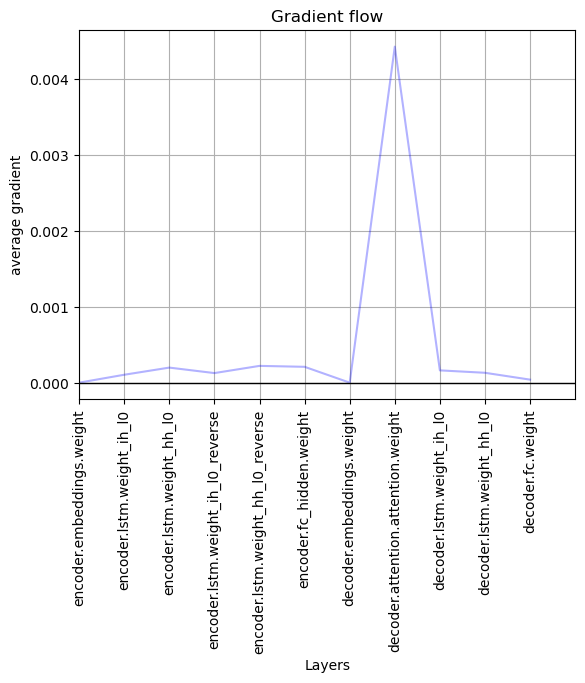

In [69]:
plot_grad_flow(model.named_parameters())

In [ ]:
import time
def writeLoss(filename, loss):
    # filename in format losstype+layer+dim, validL2D256
    timestr = time.strftime("%Y%m%d-%H%M%S")
    filename = filename + "_" + timestr + ".txt"
    with open(filename, "a") as myfile:
        for item in items:
            myfile.write(item+"\n")


In [ ]:
writeLoss("Train", train_loss)
writeLoss("Valid", eval_loss)
writeLoss("Train_acc", train_acc)
writeLoss("Valid_acc", eval_acc)

In [345]:
torch.save(model.state_dict(), 'best_decoder20230729_epoch500.pth')

In [68]:
def plot_grad_flow(named_parameters):
    ave_grads = []
    layers = []
    for n, p in named_parameters:
        #print(n)
        if(p.requires_grad) and ("bias" not in n):
            layers.append(n)
            #print(type(p.grad))
            ave_grads.append(torch.mean(torch.abs(p.grad)).cpu())
    plt.plot(ave_grads, alpha=0.3, color="b")
    plt.hlines(0, 0, len(ave_grads)+1, linewidth=1, color="k" )
    plt.xticks(range(0,len(ave_grads), 1), layers, rotation="vertical")
    plt.xlim(xmin=0, xmax=len(ave_grads))
    plt.xlabel("Layers")
    plt.ylabel("average gradient")
    plt.title("Gradient flow")
    plt.grid(True)

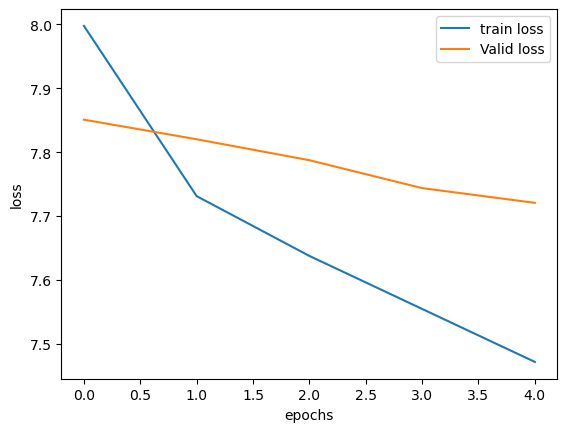

In [70]:
plt.plot(train_loss)
plt.plot(eval_loss)
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['train loss','Valid loss'])

# Model Evaluation

In [63]:
import gc
gc.collect()
torch.cuda.empty_cache()

# FastText

## Model for querying

train fasttext model
obtain weight from fasttest
then embedding can load weights

- train 2 fasttext model, 1 for text and another for abstract
- obtain weights for both vocab
- put in encoder and decoder like normal
- https://stackoverflow.com/questions/31440803/how-to-fetch-vectors-for-a-word-list-with-word2vec
- use this to update the vocab class to update ways to fetch words
- to solve querying, use the model and use function to find cosine

In [6]:
import fasttext
model = fasttext.train_unsupervised('data/fil9')
model.save_model("result/fil9.bin")
model = fasttext.load_model("result/fil9.bin")
# EXPECTS TEXT FILE FORMAT WHERE 1 TEXT PER ROW
# IMPORTANT, NEED TO REDESIGN CLEANING PROCESS 

# Dataset Exploration

After exploring, all highlight:article ratio being more than 1.0 means the summary text is producing more text than the original text, this defeats the purpose of the model, therefore all data with a ratio of more than or equal to 1.0 will be omitted.

# Model improvement/Retrain

# Model Finalisation and Evaluation

## Inference Script

In [ ]:
# Load model
best_model_path = "best_decoder20230719.pth"
best_model = Model(len(text_vocab),len(abstract_vocab),2,256)
best_model.load_state_dict(torch.load(best_model_path))

## Upload Button

In [163]:
TEXT_COLOUR = "<font color='Black'>"

In [40]:
def load_pdf(file):  
    file_content = list(file)[0]
    content = file_content["content"]
    return fitz.open(stream=content, filetype="pdf")

In [52]:
uploader = widgets.FileUpload(multiple=False, accept='.pdf')
def on_upload(change):
    #ch = change.value.values()
    # to obtain information regarding the pdf when the pdf is uploaded, buttonless design, will impact perf
    global doc_len
    doc_len = len(load_pdf(uploader.value.values()))-1
    
    uploader.value.clear()
    uploader._counter=1

uploader.observe(on_upload, 'value')
display(uploader)

-1


FileUpload(value={}, accept='.pdf', description='Upload')

## Abstract Generation tab

### Radio button for model selection

In [176]:
radio = widgets.RadioButtons(
    options=['Base', '512Dim', '1024Dim', 'Base+No Stop word'],
#    value='pineapple', # Defaults to 'pineapple'
#    layout={'width': 'max-content'}, # If the items' names are long
    description=TEXT_COLOUR+'Model:',
    disabled=False
)
display(radio)

RadioButtons(description="<font color='Black'>Model:", options=('Base', '512Dim', '1024Dim', 'Base+No Stop wor…

### 3 input box for model parameters

In [177]:
# Max Length
length = widgets.IntText(
    value=100,
    description=TEXT_COLOUR+'Max length:',
    disabled=False
)
display(length)

IntText(value=100, description="<font color='Black'>Max length:")

In [178]:
# Temperature
temperature = widgets.BoundedFloatText(
    value=0.5,
    min=0,
    max=1.0,
    step=0.1,
    description=TEXT_COLOUR+'Temperature:',
    disabled=False
)
display(temperature)

BoundedFloatText(value=0.5, description="<font color='Black'>Temperature:", max=1.0, step=0.1)

In [179]:
# PDF start and end
pdf_range = widgets.IntRangeSlider(
    value=[0, doc_len],
    min=0,
    max=doc_len,
    step=1,

    description=TEXT_COLOUR + "Page Range:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
display(pdf_range)

IntRangeSlider(value=(0, 21), continuous_update=False, description="<font color='Black'>Page Range:", max=21)

### Activation button print result to output

In [180]:
button = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
#button.style.button_color="green"
global i
i = 0
out = widgets.Output(layout={'border': '1px solid black'})
display(button, out)

def on_button_clicked(b):
    with out:
        global i
        out.clear_output()
        print(i," Button clicked.")
        i +=1

button.on_click(on_button_clicked)

Button(button_style='info', description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

Output(layout=Layout(border='1px solid black'))

### Wrap in grid widget

In [185]:
widget = [radio, length, pdf_range, temperature, button]
grid = widgets.GridBox(widget, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))
grid_list = [grid]
tab = widgets.Tab()
tab.children=grid_list
tab

## Relevance Query tab

### Text input box

In [174]:
text_box = widgets.Text(
    value='',
    placeholder='Type something',
    description=TEXT_COLOUR+'Query:',
    disabled=False   
)
display(text_box)

Text(value='', description="<font color='Black'>Query:", placeholder='Type something')

### Input box for start and end page

In [171]:
pdf_range_q = widgets.IntRangeSlider(
    value=[0, doc_len],
    min=0,
    max=doc_len,
    step=1,

    description=TEXT_COLOUR + "Page Range:",
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
)
display(pdf_range_q)

IntRangeSlider(value=(0, 21), continuous_update=False, description="<font color='Black'>Page Range:", max=21)

### Activation button print result to output

In [172]:
button_q = widgets.Button(
    description='Click me',
    disabled=False,
    button_style='info', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Click me',
    icon='check' # (FontAwesome names without the `fa-` prefix)
)
#button.style.button_color="green"
global j
j = 0
out_q = widgets.Output(layout={'border': '1px solid black'})
display(button_q, out_q)

def on_button_clicked(b):
    with out_q:
        global j
        out_q.clear_output()
        print(j," Button clicked.")
        j +=1

button_q.on_click(on_button_clicked)

Button(button_style='info', description='Click me', icon='check', style=ButtonStyle(), tooltip='Click me')

Output(layout=Layout(border='1px solid black'))

### Wrap in grid widget

In [187]:
widget_q = [text_box, pdf_range_q, button_q]
grid_q = widgets.GridBox(widget_q, layout=widgets.Layout(grid_template_columns="repeat(1, 100px)"))
grid_list_q = [grid_q]
tab = widgets.Tab()
tab.children=grid_list_q
tab

# -----------------------

# Final combined tab

In [189]:
grids = [grid, grid_q]
tabs = widgets.Tab()
tabs.children=grids
tabs_titles = ["Abstract Generation", "Relevance Query"]
for i, title in enumerate(tabs_titles):
    tabs.set_title(i, title)
display(tabs)

# -----------------------

In [10]:
# https://ipywidgets.readthedocs.io/en/stable/examples/Widget%20List.html
w = widgets.IntSlider()
out = widgets.Output(layout={'border': '1px solid black'})

In [11]:
display(out)
display(w)
#out.clear_output()
with out:
    out.clear_output()

    for i in range(5):
        print(i, 'Hello world!')

Output(layout=Layout(border='1px solid black'))

IntSlider(value=0)

In [184]:
tab_titles = ["Abstract Generation", "Relevance Query"]
tab = widgets.Tab()
items = [widgets.Label(str(i)) for i in range(8)]
grid = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))
gridlist= [grid]
for i, title in enumerate(tab_titles):
    tab.set_title(i, title)
    children = [widgets.Text(value=str(i),description=name) for name in tab_titles]
    print(children)
    tab.children=gridlist
tab

# work flow is as follows
# widget1 = widgets.button()
# widget2 = widgets.button()
# widget3 = widgets.RadioButton()
# widgetList = [widget1,widget2,widget3]
# grid1 = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))
# grid2 = widgets.GridBox(items, layout=widgets.Layout(grid_template_columns="repeat(3, 100px)"))
# grids = [grid1, grid2]

# tab.children = grids


[Text(value='0', description='Abstract Generation'), Text(value='0', description='Relevance Query')]
[Text(value='1', description='Abstract Generation'), Text(value='1', description='Relevance Query')]


In [17]:
def readPDF(file, start_page=0, end_page=-1):
    '''
    Will accept input of widget pdf file
    start_page indicates starting page to start reading default=first page
    end_page indicate last page to read default=last page
    '''
    doc = load_pdf(file)
    if end_page == -1:
        end_page = len(doc)-1
    
    # extracting text from page
    doc_text = ""
    for page in doc.pages(start_page, end_page):
        
        text = page.get_text("text")
        text = text.split('\n')
        text = " ".join(text)
        doc_text += text 
    doc_text = doc_text.strip()
    doc.close()
    return doc_text

In [ ]:
def Process(raw_data, stop_word=True):
    data = cleanLine(raw_data, stop_word)
    data_id = tokenise(text_vocab, data)
    return data_id

In [ ]:
def Infer(model, data, max_size=100, temperature=0.5):
    decoder_outputs = model(data, max_len=max_size, temperature=temperature)
    decoder_outputs = torch.unbind(decoder_outputs, 1)
    sentence = ""
    for output in decoder_outputs:
        token = output.argmax(1)
        # if word is pad then replace with space
        # if word is end then stop
        if token == 2:
            sentence += " "
        elif token == 1:
            break
        else:
            sentence += abstract_vocab.get_word(token.item()) + " "
    sentence = sentence.strip()
    return sentence

In [143]:
raw_data = readPDF(uploader.value.values(), start_page=0, end_page=-1) # Obtain 1 long string
data = Process(raw_data) # Clean string and convert to word_ids
output = Infer(best_model, data, max_size=100, temperature=0.5)